In [1]:
from kuramoto.nmf import *

In [2]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 2500
X.shape (2500, 2500)


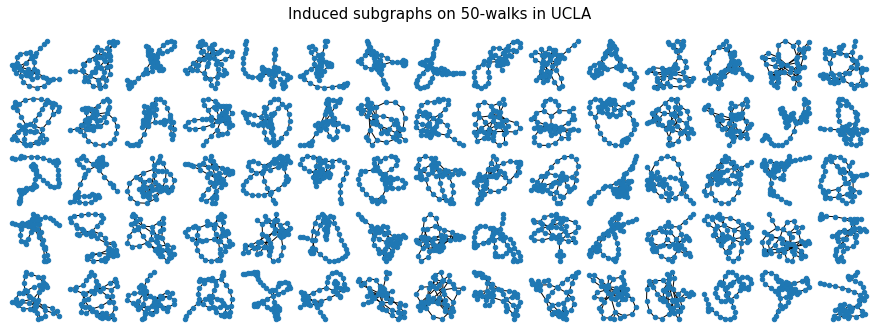

In [3]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 2500


In [5]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 3.5

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False


In [6]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.0848


In [7]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [8]:
W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  0%|▏                                   | 5/1000 [00:00<00:20, 47.69it/s]

iteration 0, reconstruction error 36898.350444


  2%|▌                                  | 15/1000 [00:00<00:27, 35.39it/s]

iteration 10, reconstruction error 16376.796726


  3%|▉                                  | 27/1000 [00:00<00:29, 33.25it/s]

iteration 20, reconstruction error 16737.933530


  4%|█▎                                 | 36/1000 [00:01<00:27, 34.62it/s]

iteration 30, reconstruction error 17076.502835


  4%|█▌                                 | 45/1000 [00:01<00:28, 34.02it/s]

iteration 40, reconstruction error 16760.894181


  6%|██▏                                | 64/1000 [00:01<00:18, 51.15it/s]

iteration 50, reconstruction error 15640.709311
iteration 60, reconstruction error 14471.544495


  8%|██▉                                | 84/1000 [00:02<00:17, 53.38it/s]

iteration 70, reconstruction error 14071.031565
iteration 80, reconstruction error 13829.046149


 10%|███▍                               | 97/1000 [00:02<00:18, 49.77it/s]

iteration 90, reconstruction error 13647.449631


 10%|███▌                              | 104/1000 [00:02<00:17, 51.02it/s]

iteration 100, reconstruction error 13512.522392


 12%|███▉                              | 116/1000 [00:02<00:20, 44.13it/s]

iteration 110, reconstruction error 13410.582155


 13%|████▎                             | 126/1000 [00:02<00:19, 44.45it/s]

iteration 120, reconstruction error 13331.581197


 14%|████▌                             | 136/1000 [00:03<00:21, 41.09it/s]

iteration 130, reconstruction error 13268.451800


 15%|████▉                             | 147/1000 [00:03<00:19, 43.98it/s]

iteration 140, reconstruction error 13216.651344
iteration 150, reconstruction error 13173.513701


 17%|█████▉                            | 173/1000 [00:03<00:14, 55.43it/s]

iteration 160, reconstruction error 13137.029636
iteration 170, reconstruction error 13105.853256


 19%|██████▌                           | 194/1000 [00:04<00:14, 57.34it/s]

iteration 180, reconstruction error 13078.520582
iteration 190, reconstruction error 13054.286480


 21%|███████                           | 208/1000 [00:04<00:13, 58.05it/s]

iteration 200, reconstruction error 13032.645537
iteration 210, reconstruction error 13013.189742


 22%|███████▋                          | 225/1000 [00:04<00:11, 66.64it/s]

iteration 220, reconstruction error 12995.496014
iteration 230, reconstruction error 12979.198888


 24%|████████▏                         | 241/1000 [00:05<00:11, 63.76it/s]

iteration 240, reconstruction error 12964.127102


 26%|████████▉                         | 262/1000 [00:05<00:14, 51.63it/s]

iteration 250, reconstruction error 12950.059706
iteration 260, reconstruction error 12936.808603


 28%|█████████▍                        | 277/1000 [00:05<00:12, 57.82it/s]

iteration 270, reconstruction error 12924.183698
iteration 280, reconstruction error 12912.086678


 30%|██████████▏                       | 300/1000 [00:06<00:10, 63.75it/s]

iteration 290, reconstruction error 12900.452199
iteration 300, reconstruction error 12889.266735


 31%|██████████▋                       | 314/1000 [00:06<00:13, 49.28it/s]

iteration 310, reconstruction error 12878.583347


 33%|███████████▏                      | 328/1000 [00:06<00:12, 55.07it/s]

iteration 320, reconstruction error 12868.379942
iteration 330, reconstruction error 12858.666875


 36%|████████████                      | 356/1000 [00:07<00:10, 63.90it/s]

iteration 340, reconstruction error 12849.505808
iteration 350, reconstruction error 12840.878316


 36%|████████████▎                     | 363/1000 [00:07<00:12, 52.36it/s]

iteration 360, reconstruction error 12832.923184


 38%|████████████▉                     | 381/1000 [00:07<00:12, 49.64it/s]

iteration 370, reconstruction error 12825.544324
iteration 380, reconstruction error 12818.753592


 40%|█████████████▌                    | 398/1000 [00:08<00:12, 47.93it/s]

iteration 390, reconstruction error 12812.489177
iteration 400, reconstruction error 12806.732495


 42%|██████████████▎                   | 421/1000 [00:08<00:09, 61.26it/s]

iteration 410, reconstruction error 12801.441904
iteration 420, reconstruction error 12796.580171


 44%|██████████████▉                   | 439/1000 [00:08<00:07, 71.71it/s]

iteration 430, reconstruction error 12792.122335
iteration 440, reconstruction error 12788.039224


 46%|███████████████▌                  | 457/1000 [00:08<00:07, 68.16it/s]

iteration 450, reconstruction error 12784.333798


 47%|████████████████                  | 472/1000 [00:09<00:08, 64.46it/s]

iteration 460, reconstruction error 12780.952743
iteration 470, reconstruction error 12777.836702


 49%|████████████████▋                 | 491/1000 [00:09<00:09, 53.53it/s]

iteration 480, reconstruction error 12774.950280
iteration 490, reconstruction error 12772.265410


 52%|█████████████████▌                | 516/1000 [00:09<00:07, 68.77it/s]

iteration 500, reconstruction error 12769.755596
iteration 510, reconstruction error 12767.400424


 53%|█████████████████▉                | 526/1000 [00:09<00:06, 73.82it/s]

iteration 520, reconstruction error 12765.182473
iteration 530, reconstruction error 12763.078325


 55%|██████████████████▌               | 547/1000 [00:10<00:08, 50.48it/s]

iteration 540, reconstruction error 12761.069814
iteration 550, reconstruction error 12759.149373


 57%|███████████████████▏              | 566/1000 [00:10<00:10, 43.17it/s]

iteration 560, reconstruction error 12757.306210


 58%|███████████████████▌              | 576/1000 [00:11<00:10, 38.95it/s]

iteration 570, reconstruction error 12755.533487


 58%|███████████████████▉              | 585/1000 [00:11<00:12, 33.44it/s]

iteration 580, reconstruction error 12753.816276


 60%|████████████████████▎             | 596/1000 [00:11<00:10, 39.19it/s]

iteration 590, reconstruction error 12752.155502


 61%|████████████████████▋             | 608/1000 [00:12<00:08, 44.47it/s]

iteration 600, reconstruction error 12750.544909


 62%|████████████████████▉             | 617/1000 [00:12<00:11, 33.29it/s]

iteration 610, reconstruction error 12748.986961


 63%|█████████████████████▎            | 628/1000 [00:12<00:09, 40.36it/s]

iteration 620, reconstruction error 12747.474932
iteration 630, reconstruction error 12746.001944


 66%|██████████████████████▎           | 655/1000 [00:12<00:05, 67.68it/s]

iteration 640, reconstruction error 12744.567129
iteration 650, reconstruction error 12743.178718


 66%|██████████████████████▌           | 663/1000 [00:13<00:05, 62.98it/s]

iteration 660, reconstruction error 12741.835314


 68%|██████████████████████▉           | 676/1000 [00:13<00:06, 53.15it/s]

iteration 670, reconstruction error 12740.534023
iteration 680, reconstruction error 12739.284130


 70%|███████████████████████▋          | 698/1000 [00:13<00:06, 45.33it/s]

iteration 690, reconstruction error 12738.107860


 71%|████████████████████████▎         | 714/1000 [00:14<00:05, 55.62it/s]

iteration 700, reconstruction error 12736.977968
iteration 710, reconstruction error 12735.886498


 73%|████████████████████████▊         | 730/1000 [00:14<00:04, 62.04it/s]

iteration 720, reconstruction error 12734.829432
iteration 730, reconstruction error 12733.801998


 75%|█████████████████████████▎        | 746/1000 [00:14<00:03, 65.03it/s]

iteration 740, reconstruction error 12732.806366


 76%|█████████████████████████▊        | 759/1000 [00:15<00:04, 49.43it/s]

iteration 750, reconstruction error 12731.836627


 76%|██████████████████████████        | 765/1000 [00:15<00:05, 45.03it/s]

iteration 760, reconstruction error 12730.904920


 78%|██████████████████████████▌       | 783/1000 [00:15<00:04, 50.25it/s]

iteration 770, reconstruction error 12730.018117
iteration 780, reconstruction error 12729.155357


 80%|███████████████████████████▏      | 798/1000 [00:15<00:03, 59.63it/s]

iteration 790, reconstruction error 12728.312869
iteration 800, reconstruction error 12727.489285


 82%|███████████████████████████▊      | 818/1000 [00:16<00:03, 47.56it/s]

iteration 810, reconstruction error 12726.687680


 82%|████████████████████████████      | 824/1000 [00:16<00:03, 45.14it/s]

iteration 820, reconstruction error 12725.916248


 84%|████████████████████████████▍     | 838/1000 [00:16<00:04, 36.48it/s]

iteration 830, reconstruction error 12725.161775


 85%|████████████████████████████▊     | 849/1000 [00:17<00:03, 40.30it/s]

iteration 840, reconstruction error 12724.424466


 86%|█████████████████████████████▎    | 861/1000 [00:17<00:03, 45.61it/s]

iteration 850, reconstruction error 12723.701830
iteration 860, reconstruction error 12722.992413


 88%|█████████████████████████████▊    | 877/1000 [00:17<00:02, 43.47it/s]

iteration 870, reconstruction error 12722.296698


 89%|██████████████████████████████    | 886/1000 [00:18<00:03, 34.32it/s]

iteration 880, reconstruction error 12721.613694


 90%|██████████████████████████████▌   | 899/1000 [00:18<00:02, 36.33it/s]

iteration 890, reconstruction error 12720.941388


 91%|██████████████████████████████▊   | 908/1000 [00:18<00:02, 34.71it/s]

iteration 900, reconstruction error 12720.280374


 92%|███████████████████████████████▏  | 916/1000 [00:18<00:02, 31.56it/s]

iteration 910, reconstruction error 12719.629662


 92%|███████████████████████████████▍  | 924/1000 [00:19<00:02, 27.63it/s]

iteration 920, reconstruction error 12718.990368


 94%|███████████████████████████████▊  | 935/1000 [00:19<00:01, 35.86it/s]

iteration 930, reconstruction error 12718.359406


 95%|████████████████████████████████▏ | 947/1000 [00:19<00:01, 33.30it/s]

iteration 940, reconstruction error 12717.736891


 96%|████████████████████████████████▋ | 960/1000 [00:20<00:00, 43.50it/s]

iteration 950, reconstruction error 12717.120802
iteration 960, reconstruction error 12716.514186


 98%|█████████████████████████████████▎| 978/1000 [00:20<00:00, 52.83it/s]

iteration 970, reconstruction error 12715.913602


 99%|█████████████████████████████████▋| 990/1000 [00:20<00:00, 47.57it/s]

iteration 980, reconstruction error 12715.320520
iteration 990, reconstruction error 12714.732925


100%|█████████████████████████████████| 1000/1000 [00:20<00:00, 47.68it/s]




###########################
Shape of W_true: (2500, 16)
###########################




  0%|                                    | 1/1000 [00:00<02:14,  7.42it/s]

iteration 0, reconstruction error 360321.446574


  1%|▍                                  | 13/1000 [00:01<01:17, 12.68it/s]

iteration 10, reconstruction error 140350.360508


  2%|▊                                  | 23/1000 [00:01<01:15, 12.87it/s]

iteration 20, reconstruction error 145142.813593


  3%|█▏                                 | 33/1000 [00:02<01:11, 13.53it/s]

iteration 30, reconstruction error 152609.368641


  4%|█▌                                 | 43/1000 [00:03<01:12, 13.25it/s]

iteration 40, reconstruction error 153512.729703


  5%|█▊                                 | 53/1000 [00:04<01:10, 13.50it/s]

iteration 50, reconstruction error 153437.696888


  6%|██▏                                | 64/1000 [00:04<01:07, 13.93it/s]

iteration 60, reconstruction error 153158.269338


  7%|██▌                                | 72/1000 [00:05<01:01, 15.03it/s]

iteration 70, reconstruction error 152484.630387


  8%|██▊                                | 82/1000 [00:06<01:12, 12.75it/s]

iteration 80, reconstruction error 150949.978425


  9%|███▏                               | 92/1000 [00:06<01:14, 12.25it/s]

iteration 90, reconstruction error 147630.159846


 10%|███▍                              | 102/1000 [00:07<01:05, 13.69it/s]

iteration 100, reconstruction error 141012.193091


 11%|███▉                              | 114/1000 [00:08<01:00, 14.54it/s]

iteration 110, reconstruction error 130821.004497


 12%|████▏                             | 123/1000 [00:09<01:04, 13.56it/s]

iteration 120, reconstruction error 123861.478122


 13%|████▌                             | 133/1000 [00:09<01:00, 14.32it/s]

iteration 130, reconstruction error 121822.969280


 14%|████▊                             | 143/1000 [00:10<01:10, 12.16it/s]

iteration 140, reconstruction error 120381.920611


 15%|█████▏                            | 153/1000 [00:11<01:03, 13.31it/s]

iteration 150, reconstruction error 119262.600148


 16%|█████▌                            | 163/1000 [00:12<01:00, 13.73it/s]

iteration 160, reconstruction error 118432.756528


 17%|█████▉                            | 173/1000 [00:12<00:55, 14.87it/s]

iteration 170, reconstruction error 117822.202787


 18%|██████▏                           | 183/1000 [00:13<01:03, 12.91it/s]

iteration 180, reconstruction error 117363.893750


 19%|██████▌                           | 193/1000 [00:14<00:57, 13.95it/s]

iteration 190, reconstruction error 117004.660180


 20%|██████▉                           | 203/1000 [00:15<01:00, 13.09it/s]

iteration 200, reconstruction error 116711.039325


 21%|███████▏                          | 213/1000 [00:15<00:57, 13.69it/s]

iteration 210, reconstruction error 116463.815124


 22%|███████▌                          | 223/1000 [00:16<00:56, 13.84it/s]

iteration 220, reconstruction error 116250.039662


 23%|███████▉                          | 233/1000 [00:17<00:50, 15.15it/s]

iteration 230, reconstruction error 116063.259223


 24%|████████▎                         | 243/1000 [00:17<00:58, 12.95it/s]

iteration 240, reconstruction error 115898.562207


 25%|████████▌                         | 253/1000 [00:18<00:56, 13.11it/s]

iteration 250, reconstruction error 115752.107965


 26%|████████▉                         | 263/1000 [00:19<00:54, 13.47it/s]

iteration 260, reconstruction error 115620.752225


 27%|█████████▎                        | 273/1000 [00:20<00:58, 12.50it/s]

iteration 270, reconstruction error 115501.132220


 28%|█████████▌                        | 283/1000 [00:20<00:59, 12.08it/s]

iteration 280, reconstruction error 115391.296202


 29%|█████████▉                        | 293/1000 [00:21<00:54, 13.08it/s]

iteration 290, reconstruction error 115289.402288


 30%|██████████▎                       | 303/1000 [00:22<00:53, 12.95it/s]

iteration 300, reconstruction error 115193.790483


 31%|██████████▋                       | 313/1000 [00:23<00:56, 12.11it/s]

iteration 310, reconstruction error 115103.107421


 32%|██████████▉                       | 322/1000 [00:24<01:03, 10.76it/s]

iteration 320, reconstruction error 115017.301136


 33%|███████████▎                      | 332/1000 [00:24<00:56, 11.73it/s]

iteration 330, reconstruction error 114936.233207


 34%|███████████▋                      | 344/1000 [00:25<00:48, 13.65it/s]

iteration 340, reconstruction error 114859.007509


 35%|███████████▉                      | 352/1000 [00:26<00:46, 13.89it/s]

iteration 350, reconstruction error 114785.050203


 36%|████████████▎                     | 362/1000 [00:27<00:48, 13.16it/s]

iteration 360, reconstruction error 114714.120526


 37%|████████████▋                     | 372/1000 [00:27<00:45, 13.95it/s]

iteration 370, reconstruction error 114646.149283


 38%|█████████████                     | 384/1000 [00:28<00:44, 13.77it/s]

iteration 380, reconstruction error 114581.169681


 39%|█████████████▎                    | 392/1000 [00:29<00:42, 14.44it/s]

iteration 390, reconstruction error 114519.203707


 40%|█████████████▋                    | 402/1000 [00:30<00:52, 11.47it/s]

iteration 400, reconstruction error 114460.363028


 41%|██████████████                    | 412/1000 [00:31<00:42, 13.68it/s]

iteration 410, reconstruction error 114404.593862


 42%|██████████████▍                   | 424/1000 [00:31<00:40, 14.16it/s]

iteration 420, reconstruction error 114351.814775


 43%|██████████████▋                   | 431/1000 [00:32<00:37, 15.02it/s]

iteration 430, reconstruction error 114301.996025


 44%|███████████████                   | 443/1000 [00:33<00:48, 11.53it/s]

iteration 440, reconstruction error 114255.074475


 45%|███████████████▍                  | 453/1000 [00:34<00:48, 11.24it/s]

iteration 450, reconstruction error 114211.063740


 46%|███████████████▋                  | 463/1000 [00:35<00:45, 11.90it/s]

iteration 460, reconstruction error 114169.916450


 47%|████████████████                  | 473/1000 [00:35<00:44, 11.94it/s]

iteration 470, reconstruction error 114131.548824


 48%|████████████████▍                 | 483/1000 [00:36<00:40, 12.81it/s]

iteration 480, reconstruction error 114095.867286


 49%|████████████████▊                 | 493/1000 [00:37<00:39, 12.84it/s]

iteration 490, reconstruction error 114062.758258


 50%|█████████████████                 | 503/1000 [00:38<00:38, 13.02it/s]

iteration 500, reconstruction error 114032.084816


 51%|█████████████████▍                | 514/1000 [00:39<00:34, 13.94it/s]

iteration 510, reconstruction error 114003.689976


 52%|█████████████████▊                | 524/1000 [00:39<00:37, 12.85it/s]

iteration 520, reconstruction error 113977.398125


 53%|██████████████████                | 532/1000 [00:40<00:40, 11.55it/s]

iteration 530, reconstruction error 113953.030142


 54%|██████████████████▍               | 544/1000 [00:41<00:31, 14.56it/s]

iteration 540, reconstruction error 113930.433404


 55%|██████████████████▊               | 552/1000 [00:41<00:30, 14.47it/s]

iteration 550, reconstruction error 113909.558833


 56%|███████████████████▏              | 564/1000 [00:42<00:31, 13.90it/s]

iteration 560, reconstruction error 113890.231235


 57%|███████████████████▌              | 574/1000 [00:43<00:29, 14.50it/s]

iteration 570, reconstruction error 113872.301245


 58%|███████████████████▊              | 583/1000 [00:44<00:27, 14.99it/s]

iteration 580, reconstruction error 113855.782512


 59%|████████████████████▏             | 593/1000 [00:44<00:29, 13.98it/s]

iteration 590, reconstruction error 113840.490153


 60%|████████████████████▌             | 603/1000 [00:45<00:29, 13.33it/s]

iteration 600, reconstruction error 113826.283383


 61%|████████████████████▊             | 613/1000 [00:46<00:31, 12.43it/s]

iteration 610, reconstruction error 113813.039896


 62%|█████████████████████▏            | 623/1000 [00:47<00:30, 12.33it/s]

iteration 620, reconstruction error 113800.662092


 63%|█████████████████████▌            | 633/1000 [00:47<00:29, 12.55it/s]

iteration 630, reconstruction error 113789.079198


 64%|█████████████████████▊            | 643/1000 [00:48<00:26, 13.42it/s]

iteration 640, reconstruction error 113778.226928


 65%|██████████████████████▏           | 653/1000 [00:49<00:28, 12.05it/s]

iteration 650, reconstruction error 113768.057266


 66%|██████████████████████▌           | 663/1000 [00:50<00:26, 12.65it/s]

iteration 660, reconstruction error 113758.525980


 67%|██████████████████████▉           | 673/1000 [00:51<00:25, 12.60it/s]

iteration 670, reconstruction error 113749.605870


 68%|███████████████████████▏          | 683/1000 [00:52<00:29, 10.60it/s]

iteration 680, reconstruction error 113741.269048


 69%|███████████████████████▌          | 693/1000 [00:52<00:23, 13.30it/s]

iteration 690, reconstruction error 113733.487134


 70%|███████████████████████▊          | 701/1000 [00:53<00:26, 11.10it/s]

iteration 700, reconstruction error 113726.208044


 71%|████████████████████████▏         | 713/1000 [00:54<00:25, 11.34it/s]

iteration 710, reconstruction error 113719.382153


 72%|████████████████████████▌         | 723/1000 [00:55<00:24, 11.42it/s]

iteration 720, reconstruction error 113712.992013


 73%|████████████████████████▉         | 733/1000 [00:56<00:21, 12.29it/s]

iteration 730, reconstruction error 113707.008846


 74%|█████████████████████████▎        | 743/1000 [00:57<00:23, 10.87it/s]

iteration 740, reconstruction error 113701.397567


 75%|█████████████████████████▌        | 753/1000 [00:58<00:20, 11.97it/s]

iteration 750, reconstruction error 113696.131327


 76%|█████████████████████████▉        | 763/1000 [00:59<00:19, 12.46it/s]

iteration 760, reconstruction error 113691.182489


 77%|██████████████████████████▎       | 773/1000 [00:59<00:20, 11.23it/s]

iteration 770, reconstruction error 113686.534115


 78%|██████████████████████████▌       | 783/1000 [01:00<00:18, 11.60it/s]

iteration 780, reconstruction error 113682.164063


 79%|██████████████████████████▉       | 793/1000 [01:01<00:16, 12.75it/s]

iteration 790, reconstruction error 113678.056240


 80%|███████████████████████████▎      | 803/1000 [01:02<00:16, 11.72it/s]

iteration 800, reconstruction error 113674.189311


 81%|███████████████████████████▋      | 813/1000 [01:03<00:16, 11.15it/s]

iteration 810, reconstruction error 113670.548304


 82%|███████████████████████████▉      | 823/1000 [01:04<00:14, 12.64it/s]

iteration 820, reconstruction error 113667.119474


 83%|████████████████████████████▎     | 833/1000 [01:04<00:13, 12.27it/s]

iteration 830, reconstruction error 113663.883719


 84%|████████████████████████████▌     | 841/1000 [01:05<00:12, 12.31it/s]

iteration 840, reconstruction error 113660.830658


 85%|█████████████████████████████     | 853/1000 [01:06<00:13, 11.10it/s]

iteration 850, reconstruction error 113657.945084


 86%|█████████████████████████████▎    | 863/1000 [01:07<00:11, 11.85it/s]

iteration 860, reconstruction error 113655.210671


 87%|█████████████████████████████▋    | 873/1000 [01:08<00:11, 10.67it/s]

iteration 870, reconstruction error 113652.615252


 88%|██████████████████████████████    | 883/1000 [01:09<00:11, 10.49it/s]

iteration 880, reconstruction error 113650.147721


 89%|██████████████████████████████▎   | 893/1000 [01:10<00:08, 12.10it/s]

iteration 890, reconstruction error 113647.797076


 90%|██████████████████████████████▋   | 903/1000 [01:10<00:07, 12.84it/s]

iteration 900, reconstruction error 113645.552679


 91%|███████████████████████████████   | 913/1000 [01:11<00:08, 10.69it/s]

iteration 910, reconstruction error 113643.404359


 92%|███████████████████████████████▍  | 923/1000 [01:12<00:06, 11.40it/s]

iteration 920, reconstruction error 113641.343304


 93%|███████████████████████████████▋  | 933/1000 [01:13<00:06, 10.72it/s]

iteration 930, reconstruction error 113639.361572


 94%|███████████████████████████████▉  | 941/1000 [01:14<00:05, 11.41it/s]

iteration 940, reconstruction error 113637.452168


 95%|████████████████████████████████▍ | 953/1000 [01:15<00:03, 12.53it/s]

iteration 950, reconstruction error 113635.608667


 96%|████████████████████████████████▋ | 963/1000 [01:16<00:02, 13.01it/s]

iteration 960, reconstruction error 113633.825462


 97%|█████████████████████████████████ | 973/1000 [01:16<00:02, 11.71it/s]

iteration 970, reconstruction error 113632.096897


 98%|█████████████████████████████████▍| 983/1000 [01:17<00:01, 12.39it/s]

iteration 980, reconstruction error 113630.417720


 99%|█████████████████████████████████▊| 993/1000 [01:18<00:00, 12.42it/s]

iteration 990, reconstruction error 113628.782928


100%|█████████████████████████████████| 1000/1000 [01:19<00:00, 12.63it/s]



###########################
Shape of W_false: (2500, 16)
###########################




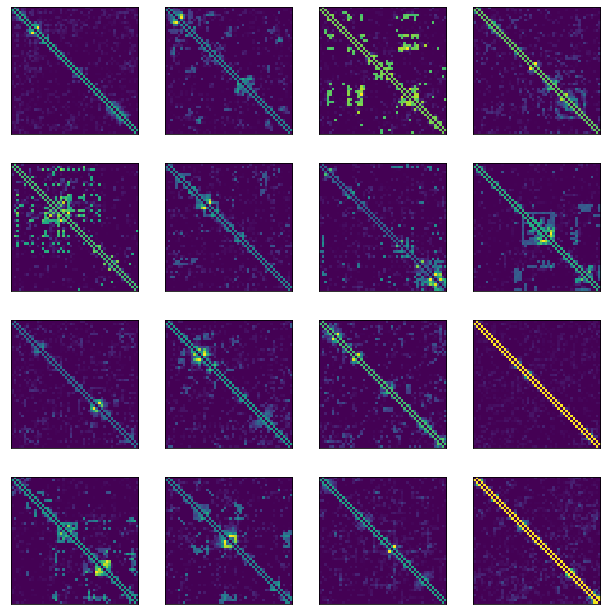

In [9]:
display_dictionary(W = W_true,
                   save_name = save_folder + ntwk_nonumber + "_Dictionary_True",
                   figsize = [10,10])

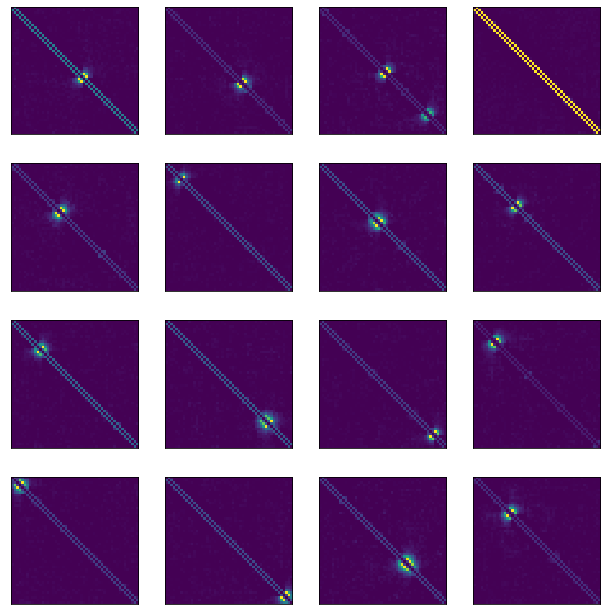

In [10]:
display_dictionary(W = W_false,
                   save_name = save_folder + ntwk_nonumber + "_Dictionary_False",
                   figsize = [10,10])

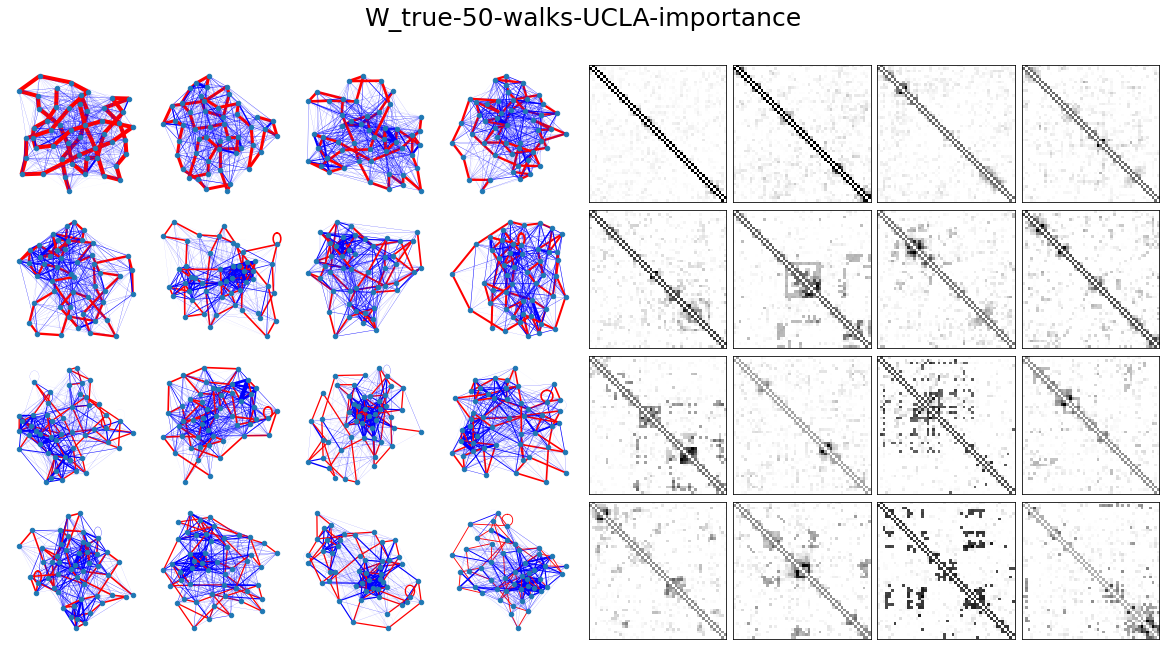

In [11]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

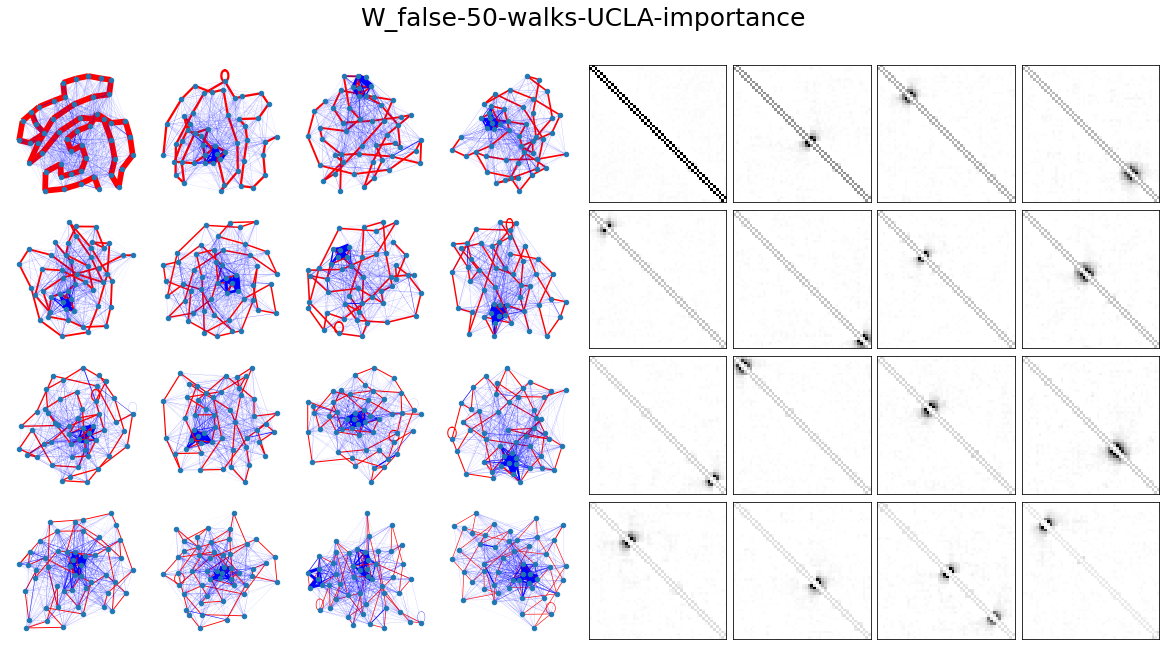

In [12]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)